## Курсовой проект для курса "Python для Data Science-2"

#### Материалы к проекту (файлы): 

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Задание: 

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная:

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Целевая метрика

F1( 𝛽
  = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

#### Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

#### Рекомендации для файла с кодом (ipynb)

1.Файл должен содержать заголовки и комментарии (markdown)

2.Повторяющиеся операции лучше оформлять в виде функций

3.Не делать вывод большого количества строк таблиц (5-10 достаточно)

4.По возможности добавлять графики, описывающие данные (около 3-5)

5.Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта

6.Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)

7.Весь проект должен быть в одном скрипте (файл ipynb).

8.Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

### Обзор данных¶

#### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Score - кредитный рейтинг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Подключение библиотек и скриптов

In [1]:
!pip install catboost


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import catboost as catb
#import lightgbm as lgbm
import scipy.stats as stats
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
#from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
import warnings
warnings.simplefilter('ignore')
import random

#### Пути к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

#### Загрузка данных

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_test.shape

(2500, 16)

#### Обзор данных

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
#Количественные переменные.

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [12]:
#Качественные переменные
df_train.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [13]:
df_train['Years in current job'].value_counts() 

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [14]:
#Обзор целевой переменной
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [15]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [16]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


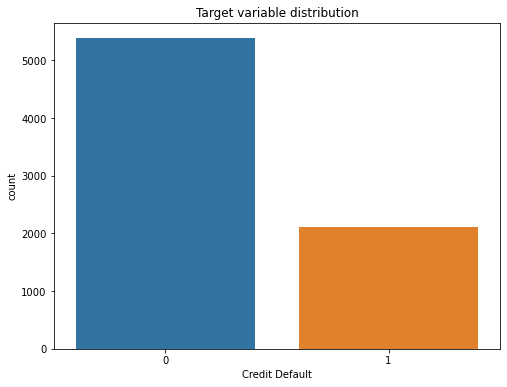

In [17]:
#Распределение значений целевой переменной 
#в абсолютных значениях:

plt.figure(figsize=(8, 6))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

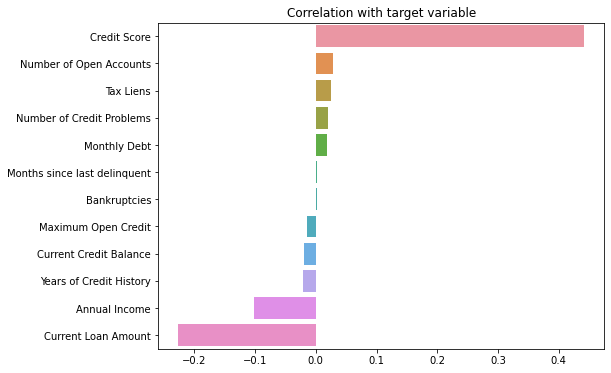

In [18]:
# В корреляции с целевой переменной:

corr_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(x=corr_target.values, y=corr_target.index)

plt.title('Correlation with target variable')
plt.show()

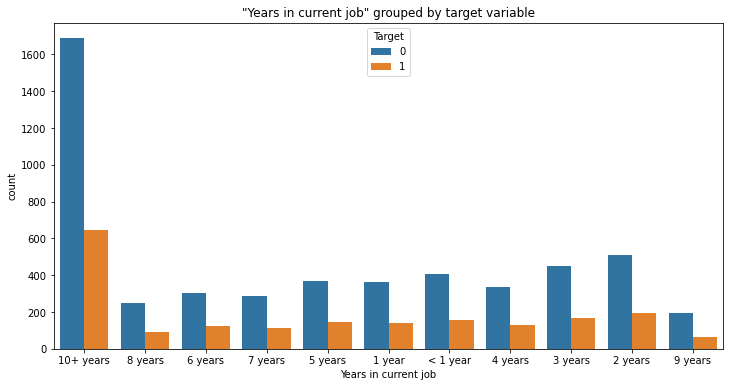

In [19]:
#в зависимости от стажа работы:

plt.figure(figsize=(12, 6))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train) 
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper center')

plt.show()

#### Обработка пропусков

In [20]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [21]:
#Изменение пропусков в 'Months since last delinquent' на 0 

df_train['Months since last delinquent'].fillna(0, inplace=True)

In [22]:
# Для обработки пропусков по доходу создается новый бинарный признак (1/0)

df_train['income_none'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'income_none'] = 1

# заполнение по медиане

income_none_median = df_train['Annual Income'].median()
df_train['Annual Income'].fillna(income_none_median, inplace=True)

In [23]:
# Еще один бинарный признак (1/0) по просрочке платежей
df_train['delay_pay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'delay_pay'] = 0

In [24]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
income_none                        0
delay_pay                          0
dtype: int64

In [25]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,income_none,delay_pay
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0


In [26]:
NEW_FEATURE_NAMES = ['delay_pay','income_none']

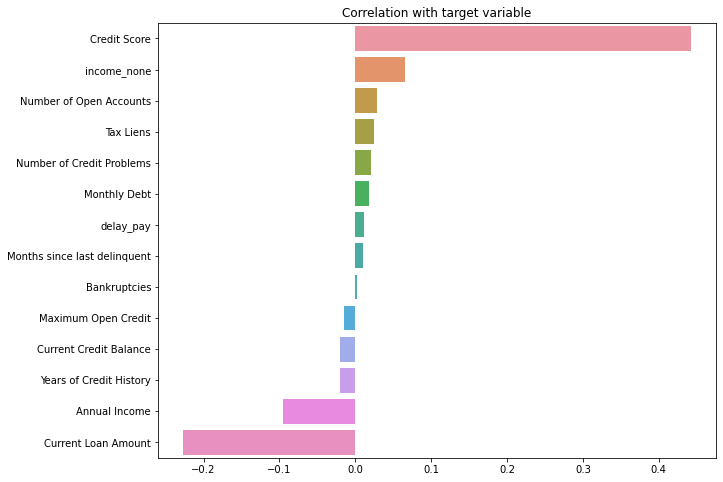

In [27]:
# Посмотрим на корреляцию с целевой переменной

corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

График показал увеличение корреляции по признаку 'Months since last delinquent'

In [28]:
# Имеем большое количество пропусков по 'Credit score'
# Добавление бинарной переменной (1/0)

df_train['credit_score_none'] = 0
df_train.loc[(df_train['Credit Score'].isnull()), 'credit_score_none'] = 1 

In [29]:
#пропуски заполняются медианой
credit_score_median = df_train['Credit Score'].median()
df_train['Credit Score'].fillna(credit_score_median, inplace=True)

In [30]:
# Обработка пропусков 'Years in current job'

years_in_current_job = df_train['Years in current job'].unique()
var_experiance = years_in_current_job[1:]
df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [31]:
#Обработка пропусков по банкротству

df_train['Bankruptcies'].fillna(0 , inplace=True)

In [32]:
df_train.Bankruptcies.value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [33]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
income_none                     0
delay_pay                       0
credit_score_none               0
dtype: int64

Все пропуски обработаны

#### Обработка выбросов

In [34]:
# Обнаружены выбросы по текущей сумме кредита, замена на медиану

median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [35]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,income_none,delay_pay,credit_score_none
0,Own Home,482087.0,9 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,0


In [36]:
NEW_FEATURE_NAMES = ['delay_pay','income_none','credit_score_none']

In [37]:
#получение отчета о классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [38]:
# Сбалансировать датафрейм по целевым переменным
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [39]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,income_none,delay_pay,credit_score_none
0,Own Home,482087.0,9 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,0


#### Нормализация

In [40]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

In [41]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Years in current job    category
Home Ownership          category
Purpose                 category
Term                    category
dtype: object

In [42]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES

X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

In [43]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

#### Модель CatBoost

In [44]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3768
           1       0.99      0.52      0.68      1482

    accuracy                           0.86      5250
   macro avg       0.91      0.76      0.79      5250
weighted avg       0.88      0.86      0.85      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1619
           1       0.72      0.26      0.38       631

    accuracy                           0.76      2250
   macro avg       0.74      0.61      0.62      2250
weighted avg       0.76      0.76      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1555   64
1                467  164


In [45]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

In [46]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [47]:
cv = KFold(n_splits=3, random_state=11, shuffle=True)

In [48]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001C0504DD670>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [49]:
#лучшие параметры
rs.best_params_

{'n_estimators': 50, 'max_depth': 5}

In [50]:
#лучший результат
rs.best_score_

0.5269187188765659

#### Борьба с переобучением

In [51]:

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.99      0.88      3768
           1       0.95      0.31      0.47      1482

    accuracy                           0.80      5250
   macro avg       0.87      0.65      0.67      5250
weighted avg       0.83      0.80      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1619
           1       0.80      0.24      0.37       631

    accuracy                           0.77      2250
   macro avg       0.78      0.61      0.61      2250
weighted avg       0.78      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1582   37
1                481  150


#### Обработка тестового df (пропуски, выбросы)

In [52]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [53]:
df_test['Months since last delinquent'].fillna(0, inplace=True)

In [54]:
df_test['income_none'] = 0
df_test.loc[(df_test['Annual Income'].isnull()), 'income_none'] = 1

income_none_median = df_test['Annual Income'].median()
df_test['Annual Income'].fillna(income_none_median, inplace=True)

In [55]:
df_test['delay_pay'] = 1
df_test.loc[(df_test['Months since last delinquent'] == 0), 'delay_pay'] = 0

In [56]:
df_test['credit_score_none'] = 0
df_test.loc[(df_test['Credit Score'].isnull()), 'credit_score_none'] = 1 


In [57]:
credit_score_median = df_test['Credit Score'].median()
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

In [58]:
years_in_current_job = df_test['Years in current job'].unique()
var_experiance = years_in_current_job[1:]
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [59]:
df_test['Bankruptcies'].fillna(0 , inplace=True)
df_test.Bankruptcies.value_counts()

0.0    2255
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [60]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
income_none                     0
delay_pay                       0
credit_score_none               0
dtype: int64

пропуски обработаны

In [61]:
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [62]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,income_none,delay_pay,credit_score_none
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,1,1,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,1,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,0,0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,0,1,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,0,0,0


выбросы обработаны

In [63]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,delay_pay,income_none,credit_score_none
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,731.0,1,1,1
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,1,0,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,0,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,1,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,0,0,0


In [64]:
y_pred_output = final_model.predict(df_for_model)
y_pred_output.shape

(2500,)

In [65]:
#предсказание записывается в виде таблицы и сохраныем в файл IBlinova_solution.csv
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [66]:
result_pred ='./IBlinova_solution.csv'
result.to_csv(result_pred, index=False)

In [67]:
df_sample = pd.read_csv('IBlinova_solution.csv')
predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
Id,
0,1
1,1
2,1
3,1
4,1
...,...
2495,1
2496,1
2497,1
